In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# exporting to latex
import tabulate
from tabulate import tabulate

# Defining number of month for the test set (to change the test range just change here),
# starting and end date for the data set
# (mandatory : starting because of google trends data and end because of CPI data)
nb_month = 12
start_date = pd.Timestamp('2004-01-01')
end_date = pd.Timestamp('2022-02-01')
threshold_date_2 = end_date - pd.DateOffset(months=nb_month)
threshold_date_1 = end_date - pd.DateOffset(months=nb_month+1)

# Note that results can change from the report since Google trends data can change depending of the time we take it

# 1) Data preparation

## Getting the CPI

In [2]:
# Get the CPI data from a csv file
# get only data from 2004 since this is the start of our google trends
CPI_raw = pd.read_csv (r'data_google_trends\CPIAUCSL.csv')
CPI = pd.DataFrame(data=CPI_raw["CPIAUCSL"])
CPI.index = pd.period_range(start= CPI_raw["DATE"][0],end=CPI_raw["DATE"][len(CPI_raw)-1],freq='M')
CPI=CPI[start_date:end_date]
CPI.columns = ["CPI"]
CPI_test = CPI[threshold_date_2:end_date]
CPI_train = CPI[start_date:threshold_date_1]
print(CPI,CPI_train,CPI_test)

             CPI
2004-01  186.300
2004-02  186.700
2004-03  187.100
2004-04  187.400
2004-05  188.200
...          ...
2021-10  276.590
2021-11  278.524
2021-12  280.126
2022-01  281.933
2022-02  284.182

[218 rows x 1 columns]              CPI
2004-01  186.300
2004-02  186.700
2004-03  187.100
2004-04  187.400
2004-05  188.200
...          ...
2020-09  260.190
2020-10  260.352
2020-11  260.721
2020-12  261.564
2021-01  262.200

[205 rows x 1 columns]              CPI
2021-02  263.346
2021-03  265.028
2021-04  266.727
2021-05  268.599
2021-06  270.955
2021-07  272.184
2021-08  273.092
2021-09  274.214
2021-10  276.590
2021-11  278.524
2021-12  280.126
2022-01  281.933
2022-02  284.182


## Using an API

We use a built API to download the Google trends quicker from the provider.
We download the training set separately from the test set so that it is free from look ahead bias and so the test set is not down-scaled by the training set. We then merge them in a single data set.

In [3]:
import pytrends
from pytrends.request import TrendReq

# Not run this code too much times max query is around 100 per day
kw_list = ["Amazon","Booking","Car","Crisis","Flight","Ford","Fridge","Glassdoor","Holidays",\
           "Housing","Inflation","Las Vegas","Linkedin","Oil",\
           "Unemployment Benefits", "Unemployment Insurance","USAjobs"]
# language of query is US english
pytrends = TrendReq(hl='en-US', tz=360)

In [4]:
# For the traing set (do not run it too much time within a short period)

trends_train = dict()
for i in kw_list:
   # build out query
   pytrends.build_payload([i,'Canada'], cat=0,timeframe='{} {}'.format(start_date.date(), threshold_date_1.date()),geo="US")
   # save trend to dictionary
   trends_train[i] = pytrends.interest_over_time()[i]

data_api_train = pd.DataFrame.from_dict(trends_train)
data_api_train.index =  pd.period_range(start= start_date.date(),end=threshold_date_1.date(),freq='M')

In [5]:
# For the test set (do not run it too much time within a short period)

trends_test = dict()

for i in kw_list:
   # build out query
   pytrends.build_payload([i,'Canada'], cat=0, timeframe='{} {}'.format(start_date.date(), end_date.date()), geo="US")
   # save trend to dictionary
   trends_test[i] = pytrends.interest_over_time()[i]

data_api_test_ = pd.DataFrame.from_dict(trends_test)
data_api_test_ = data_api_test_[threshold_date_2.date():end_date.date()]

In [6]:
#taking only part of interest
data_api_test = data_api_test_
data_api_test.index =  pd.period_range(start= threshold_date_2.date(), end=end_date.date(),freq='M')

In [7]:
# Merging with CPI

data_api_train = pd.concat([data_api_train, CPI_train], axis=1)
data_api_test = pd.concat([data_api_test, CPI_test], axis=1)

In [8]:
display(data_api_train, data_api_test)

,Amazon,Booking,Car,Crisis,Flight,Ford,Fridge,Glassdoor,Holidays,Housing,Inflation,Las Vegas,Linkedin,Oil,Unemployment Benefits,Unemployment Insurance,USAjobs,CPI
2004-01,9,3,80,7,37,68,1,0,5,31,4,47,0,32,1,2,3,186.300
2004-02,8,3,77,8,33,71,1,0,4,31,4,41,0,32,1,1,2,186.700
2004-03,8,3,81,9,35,70,1,0,3,34,5,42,0,30,1,1,2,187.100
2004-04,8,3,84,10,34,71,1,0,4,34,5,39,0,35,1,1,2,187.400
2004-05,9,3,84,9,37,71,1,0,4,32,4,40,0,37,1,1,2,188.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09,75,7,85,8,39,75,19,6,3,27,4,32,35,72,11,1,2,260.190
2020-10,84,7,87,8,38,80,19,6,3,27,4,32,31,74,8,1,2,260.352
2020-11,86,6,77,7,38,72,22,4,4,24,4,29,25,70,6,1,2,260.721
2020-12,100,6,81,7,48,77,21,4,100,24,4,27,25,74,9,1,2,261.564


,Amazon,Booking,Car,Crisis,Flight,Ford,Fridge,Glassdoor,Holidays,Housing,Inflation,Las Vegas,Linkedin,Oil,Unemployment Benefits,Unemployment Insurance,USAjobs,CPI
2021-02,76,8,85,8,47,85,20,5,3,30,6,33,31,78,8,1,2,263.346
2021-03,79,9,93,11,50,91,19,5,3,31,6,39,30,79,8,1,2,265.028
2021-04,74,9,93,9,52,88,18,5,3,32,5,39,38,77,6,1,2,266.727
2021-05,73,10,98,9,57,88,20,5,3,31,8,44,33,77,6,1,2,268.599
2021-06,77,10,100,6,66,94,21,6,3,32,6,44,33,76,5,1,2,270.955
2021-07,73,11,100,6,76,89,22,6,3,33,5,46,30,75,4,1,2,272.184
2021-08,73,9,94,7,69,86,22,5,2,35,5,40,31,78,5,1,2,273.092
2021-09,72,9,88,8,60,79,20,5,3,31,5,39,32,74,4,1,2,274.214
2021-10,73,9,83,8,61,81,20,5,4,30,7,40,31,81,2,0,2,276.590
2021-11,83,9,85,8,64,83,24,5,10,30,9,39,31,82,1,0,2,278.524


We try an option when we normalize the data taking the growth instead of indexes. Th results given are not so good so we keep it here but we wont use it to model the inflation.

In [9]:
# To normalize the data we compute the growth of each of the words

# for training set
period = pd.period_range(start='2004-02-01',end='2021-01-01',freq='M')
data_train_growth = data_api_train.loc[period]
for t in period:
        data_train_growth.loc[t] = (data_api_train.loc[t] - data_api_train.loc[t-1])
        
# for test set        
period = pd.period_range(start='2021-03-01',end='2022-02-01',freq='M')
data_test_growth = data_api_test.loc[period]
for t in period:
        data_test_growth.loc[t] = (data_api_test.loc[t] - data_api_test.loc[t-1])
        
        
display(data_train_growth, data_test_growth)

,Amazon,Booking,Car,Crisis,Flight,Ford,Fridge,Glassdoor,Holidays,Housing,Inflation,Las Vegas,Linkedin,Oil,Unemployment Benefits,Unemployment Insurance,USAjobs,CPI
2004-02,-1.0,0.0,-3.0,1.0,-4.0,3.0,0.0,0.0,-1.0,0.0,0.0,-6.0,0.0,0.0,0.0,-1.0,-1.0,0.400
2004-03,0.0,0.0,4.0,1.0,2.0,-1.0,0.0,0.0,-1.0,3.0,1.0,1.0,0.0,-2.0,0.0,0.0,0.0,0.400
2004-04,0.0,0.0,3.0,1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,-3.0,0.0,5.0,0.0,0.0,0.0,0.300
2004-05,1.0,0.0,0.0,-1.0,3.0,0.0,0.0,0.0,0.0,-2.0,-1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.800
2004-06,0.0,0.0,4.0,-1.0,7.0,-2.0,0.0,0.0,-1.0,2.0,0.0,1.0,0.0,-1.0,0.0,0.0,1.0,0.700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09,-5.0,-1.0,-5.0,1.0,-5.0,-9.0,-4.0,-1.0,1.0,-4.0,0.0,2.0,-2.0,-4.0,-4.0,-1.0,0.0,0.610
2020-10,9.0,0.0,2.0,0.0,-1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,2.0,-3.0,0.0,0.0,0.162
2020-11,2.0,-1.0,-10.0,-1.0,0.0,-8.0,3.0,-2.0,1.0,-3.0,0.0,-3.0,-6.0,-4.0,-2.0,0.0,0.0,0.369
2020-12,14.0,0.0,4.0,0.0,10.0,5.0,-1.0,0.0,96.0,0.0,0.0,-2.0,0.0,4.0,3.0,0.0,0.0,0.843


,Amazon,Booking,Car,Crisis,Flight,Ford,Fridge,Glassdoor,Holidays,Housing,Inflation,Las Vegas,Linkedin,Oil,Unemployment Benefits,Unemployment Insurance,USAjobs,CPI
2021-03,3.0,1.0,8.0,3.0,3.0,6.0,-1.0,0.0,0.0,1.0,0.0,6.0,-1.0,1.0,0.0,0.0,0.0,1.682
2021-04,-5.0,0.0,0.0,-2.0,2.0,-3.0,-1.0,0.0,0.0,1.0,-1.0,0.0,8.0,-2.0,-2.0,0.0,0.0,1.699
2021-05,-1.0,1.0,5.0,0.0,5.0,0.0,2.0,0.0,0.0,-1.0,3.0,5.0,-5.0,0.0,0.0,0.0,0.0,1.872
2021-06,4.0,0.0,2.0,-3.0,9.0,6.0,1.0,1.0,0.0,1.0,-2.0,0.0,0.0,-1.0,-1.0,0.0,0.0,2.356
2021-07,-4.0,1.0,0.0,0.0,10.0,-5.0,1.0,0.0,0.0,1.0,-1.0,2.0,-3.0,-1.0,-1.0,0.0,0.0,1.229
2021-08,0.0,-2.0,-6.0,1.0,-7.0,-3.0,0.0,-1.0,-1.0,2.0,0.0,-6.0,1.0,3.0,1.0,0.0,0.0,0.908
2021-09,-1.0,0.0,-6.0,1.0,-9.0,-7.0,-2.0,0.0,1.0,-4.0,0.0,-1.0,1.0,-4.0,-1.0,0.0,0.0,1.122
2021-10,1.0,0.0,-5.0,0.0,1.0,2.0,0.0,0.0,1.0,-1.0,2.0,1.0,-1.0,7.0,-2.0,-1.0,0.0,2.376
2021-11,10.0,0.0,2.0,0.0,3.0,2.0,4.0,0.0,6.0,0.0,2.0,-1.0,0.0,1.0,-1.0,0.0,0.0,1.934
2021-12,8.0,-1.0,-5.0,-1.0,9.0,-2.0,-2.0,-1.0,-1.0,-3.0,-1.0,-1.0,-3.0,-12.0,0.0,0.0,0.0,1.602


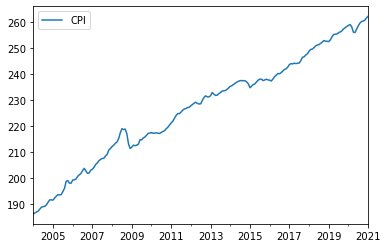

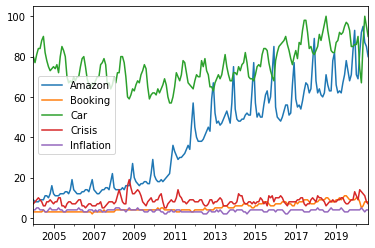

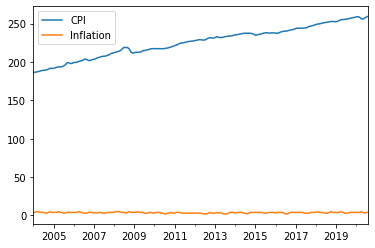

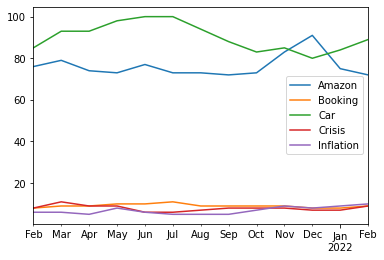

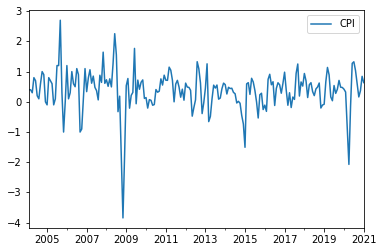

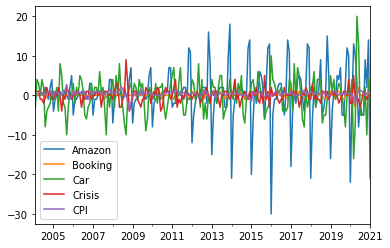

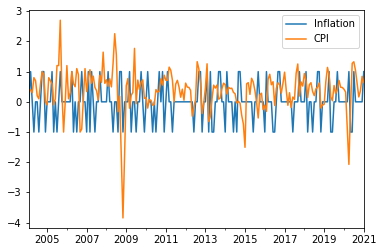

In [10]:
# Plot of the data first 50 months
data_api_train.plot(kind='line',y=["CPI"])
data_api_train[0:200].plot(kind='line',y=["Amazon","Booking","Car","Crisis","Inflation"])
data_api_train[0:200].plot(kind='line',y=["CPI","Inflation"])

data_api_test[0:200].plot(kind='line',y=["Amazon","Booking","Car","Crisis","Inflation"])


data_train_growth.plot(kind='line',y=["CPI"])
data_train_growth.plot(kind='line',y=["Amazon","Booking","Car","Crisis", "CPI"])
data_train_growth.plot(kind='line',y=["Inflation", "CPI"])

# 2) OLS

In this section we perform OLS regressions and then test the goodness of fit. First we try with only one word and the full set of words to be familiar with how words a reacting in an OLS environnement. Then we refine the model using p-value backward selection from the full model and also a VIF chack for auto correlation.

In [11]:
# Defining which set is the data set to perform regression (the raw data or the normalized one)
# either data_api_"train/test" or data_"train/test"_growth
data_train = data_api_train
data_test = data_api_test

# data_train["Summer"] = np.where((data_train.index.month>=6),1,0)*np.where((data_train.index.month<9),1,0)
# data_test["Summer"] = np.where((data_test.index.month>=6),1,0)*np.where((data_test.index.month<9),1,0)
# data_train["Autumn"] = np.where((data_train.index.month>=9),1,0)*np.where((data_train.index.month<12),1,0)
# data_test["Autumn"] = np.where((data_test.index.month>=9),1,0)*np.where((data_test.index.month<12),1,0)
# data_train["Winter"] = np.where((data_train.index.month==12),1,0)+np.where((data_train.index.month<3),1,0)
# data_test["Winter"] = np.where((data_test.index.month==12),1,0)+np.where((data_test.index.month<3),1,0)

### A first try

To familiarize with the data we first just use Car trend to predict CPI 

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     64.24
Date:                Sun, 19 Jun 2022   Prob (F-statistic):           8.55e-14
Time:                        12:56:04   Log-Likelihood:                -881.75
No. Observations:                 205   AIC:                             1767.
Df Residuals:                     203   BIC:                             1774.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        148.0267      9.910     14.938      0.0

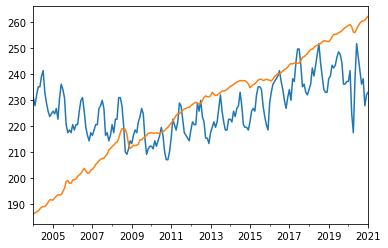

In [12]:
# Model_test

y_test = data_test["CPI"]
X_test_ = data_test["Car"]
X_test = sm.add_constant(X_test_, has_constant='add')

y_train = data_train["CPI"]
X_train_ = data_train["Car"]
X_train = sm.add_constant(X_train_)

model_test = sm.OLS(y_train, X_train).fit()
print(model_test.summary())
 
# calculate estimated CPI from inflation google trend
y_fit = model_test.predict(X_train)
 
# plotting the regression line
y_fit.plot(kind='line', label='Estimation')
y_train.plot(kind='line', label='True Value')
plt.show()


### Full Model

Now we try to find a model using all words selected.

We drop USAJobs word because we found highly colinear and poorly relevant.

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     316.5
Date:                Sun, 19 Jun 2022   Prob (F-statistic):          1.54e-126
Time:                        12:56:07   Log-Likelihood:                -568.61
No. Observations:                 205   AIC:                             1171.
Df Residuals:                     188   BIC:                             1228.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    211

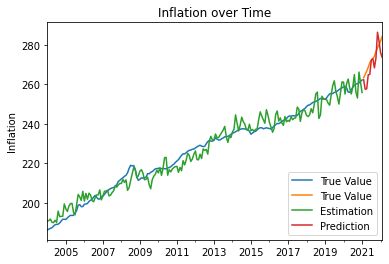

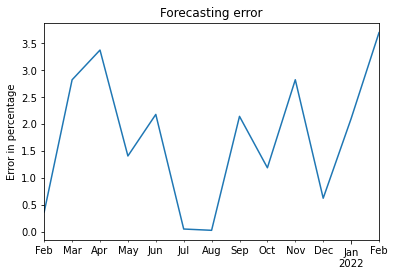

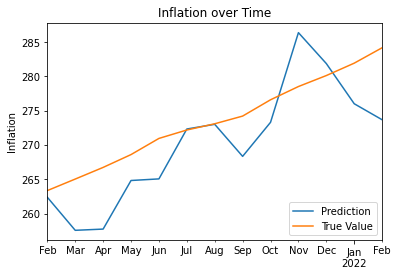

In [13]:
# Model 2 - Full OLS with google trends

y_test = data_test["CPI"]
X_test_ = data_test.drop(columns=["CPI","USAjobs"])
X_test = sm.add_constant(X_test_, has_constant='add')

y_train = data_train["CPI"]
X_train_ = data_train.drop(columns=["CPI","USAjobs"])
X_train = sm.add_constant(X_train_)

model_all = sm.OLS(y_train, X_train).fit()
print(model_all.summary())
print(model_all.fvalue)

# Prediction
y_pred = model_all.predict(X_test)

# Plot prediction vs realized
data_train["CPI"].plot(kind='line', label='True Value')
data_test["CPI"].plot(kind='line', label='True Value')
model_all.predict(X_train).plot(kind='line', label='Estimation')
y_pred.plot(kind='line', label='Prediction')
plt.ylabel('Inflation')
plt.legend(loc='lower right')
plt.title("Inflation over Time")
plt.show()

# Error in percentage
error = abs(y_pred - y_test)/y_test * 100
error.plot(kind='line', label='Relative error')
plt.ylabel('Error in percentage')
plt.title("Forecasting error")
plt.show()

# Focus in prediction part
y_pred.plot(kind='line', label='Prediction')
y_test.plot(kind='line', label='True Value')
plt.ylabel('Inflation')
plt.legend(loc='lower right')
plt.title("Inflation over Time")
plt.show()


In [ ]:
# exporting to latex
for table in model_all.summary().tables:
    print(table.as_latex_tabular())

In [14]:
# Check for multicolinerity with VIF ( rule of thumb < max(10,1/1-R^2) )
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_.values, i) for i in range(len(X_train_.columns))]
vif_data = vif_data.sort_values("VIF", ascending=False)

print(vif_data)

                   feature         VIF
2                      Car  396.579549
5                     Ford  390.833650
9                  Housing  158.295875
1                  Booking  132.034388
4                   Flight  109.273098
0                   Amazon   93.231788
6                   Fridge   91.670836
13                     Oil   81.324853
11               Las Vegas   80.565660
10               Inflation   55.879032
3                   Crisis   34.832550
7                Glassdoor   34.116110
12                Linkedin   22.950352
15  Unemployment Insurance   15.099987
14   Unemployment Benefits   14.552870
8                 Holidays    1.626389


In [ ]:
# exporting to latex
print(tabulate(vif_data, tablefmt="latex", floatfmt=".2f"))

### Refinement for a better model

We now perform what is called a bacward elimination : we start from the previous full model and we drop coeeficients having a too high p-value (here "too high" means above 0.05).

In [15]:
# Automatisation of a backward selection, we set a treshold and if the p value is higher than it,
# we delete the corresponding word form the model
def backward_regression(X, y,
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop  with p-value '.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

selection = backward_regression(X_train_,y_train)

Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 
Drop  with p-value 


In [18]:
selection

['Car', 'Flight', 'Ford', 'Fridge', 'Housing', 'Linkedin', 'Oil']

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     681.6
Date:                Sun, 19 Jun 2022   Prob (F-statistic):          2.34e-134
Time:                        13:01:49   Log-Likelihood:                -579.10
No. Observations:                 205   AIC:                             1174.
Df Residuals:                     197   BIC:                             1201.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        220.3178      3.919     56.216      0.0

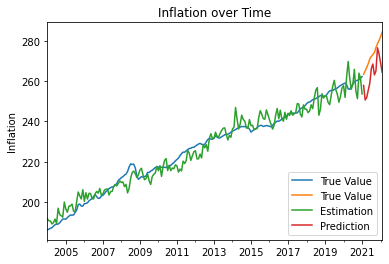

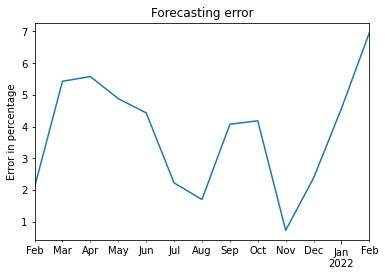

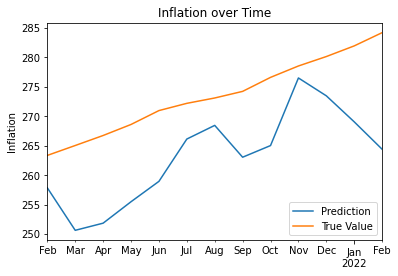

In [19]:
# Selecting best model
y_test = data_test["CPI"]
X_test_ = data_test[selection]
X_test = sm.add_constant(X_test_, has_constant='add')

y_train = data_train["CPI"]
X_train_ = data_train[selection]
X_train = sm.add_constant(X_train_)

model_2 = sm.OLS(y_train, X_train)
model_2 = model_2.fit()
print(model_2.summary())
print(model_2.fvalue)

# Prediction
y_pred = model_2.predict(X_test)

# Plot prediction vs realized
data_train["CPI"].plot(kind='line', label='True Value')
data_test["CPI"].plot(kind='line', label='True Value')
model_2.predict(X_train).plot(kind='line', label='Estimation')
y_pred.plot(kind='line', label='Prediction')
plt.ylabel('Inflation')
plt.legend(loc='lower right')
plt.title("Inflation over Time")
plt.show()

# Error in percentage
error = abs(y_pred - y_test)/y_test * 100
error.plot(kind='line', label='Relative error')
plt.ylabel('Error in percentage')
plt.title("Forecasting error")
plt.show()

# Focus in prediction part
y_pred.plot(kind='line', label='Prediction')
y_test.plot(kind='line', label='True Value')
plt.ylabel('Inflation')
plt.legend(loc='lower right')
plt.title("Inflation over Time")
plt.show()

In [21]:
print(selection)

['Car', 'Flight', 'Ford', 'Fridge', 'Housing', 'Linkedin', 'Oil']


In [ ]:
# exporting to latex
for table in model_2.summary().tables:
    print(table.as_latex_tabular())

In [20]:
# Check for multicolinerity with VIF ( rule of thumb < max(10,1/1-R^2) )
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_.values, i) for i in range(len(X_train_.columns))]
vif_data = vif_data.sort_values("VIF", ascending=False)

print(vif_data)

    feature         VIF
0       Car  335.139992
2      Ford  286.760402
4   Housing   89.431125
6       Oil   60.411096
1    Flight   43.784114
3    Fridge   13.817064
5  Linkedin    8.743272


In [ ]:
# exporting to latex
print(tabulate(vif_data, tablefmt="latex", floatfmt=".2f"))

Looking at VIF we can see some are still pretty high, as expected "Ford" and "Car" must be colinear so we decide to drop "Ford" from the words.

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     699.9
Date:                Sun, 19 Jun 2022   Prob (F-statistic):          3.66e-124
Time:                        13:02:10   Log-Likelihood:                -610.39
No. Observations:                 205   AIC:                             1233.
Df Residuals:                     199   BIC:                             1253.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        216.2463      3.732     57.951      0.0

<ipython-input-22-c371113dce72>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_["Settlement"] = (data_test["Car"] + data_test["Housing"])
<ipython-input-22-c371113dce72>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_["Settlement"] = (data_train["Car"] + data_train["Housing"])


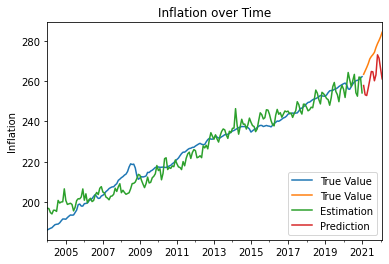

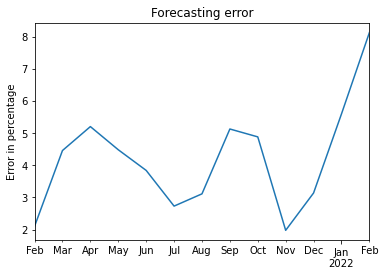

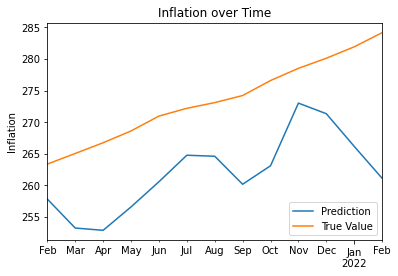

In [22]:
# Selecting best model

selection.remove("Car")
selection.remove("Housing")
selection.remove("Ford")

y_test = data_test["CPI"]
X_test_ = data_test[selection]
X_test_["Settlement"] = (data_test["Car"] + data_test["Housing"])
X_test = sm.add_constant(X_test_, has_constant='add')

y_train = data_train["CPI"]
X_train_ = data_train[selection]
X_train_["Settlement"] = (data_train["Car"] + data_train["Housing"])
X_train = sm.add_constant(X_train_)

model_3 = sm.OLS(y_train, X_train)
model_3 = model_3.fit()
print(model_3.summary())
print(model_3.fvalue)

# Prediction
y_pred = model_3.predict(X_test)

# Plot prediction vs realized
data_train["CPI"].plot(kind='line', label='True Value')
data_test["CPI"].plot(kind='line', label='True Value')
model_3.predict(X_train).plot(kind='line', label='Estimation')
y_pred.plot(kind='line', label='Prediction')
plt.ylabel('Inflation')
plt.legend(loc='lower right')
plt.title("Inflation over Time")
plt.show()

# Error in percentage
error = abs(y_pred - y_test)/y_test * 100
error.plot(kind='line', label='Relative error')
plt.ylabel('Error in percentage')
plt.title("Forecasting error")
plt.show()

# Focus in prediction part
y_pred.plot(kind='line', label='Prediction')
y_test.plot(kind='line', label='True Value')
plt.ylabel('Inflation')
plt.legend(loc='lower right')
plt.title("Inflation over Time")
plt.show()

In [ ]:
# exporting to latex
for table in model_3.summary().tables:
    print(table.as_latex_tabular())

In [23]:
# Check for multicolinerity with VIF ( rule of thumb < max(10,1/1-R^2) )

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_.values, i) for i in range(len(X_train_.columns))]
vif_data = vif_data.sort_values("VIF", ascending=False)

print(vif_data)

      feature        VIF
3         Oil  56.927153
0      Flight  41.897836
4  Settlement  35.857440
1      Fridge   8.553720
2    Linkedin   7.098567


In [ ]:
# exporting to latex
print(tabulate(vif_data, tablefmt="latex", floatfmt=".2f"))

<ipython-input-24-8167aee02c07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_["Settlement"] = (data_test["Car"] + data_test["Housing"] + data_test["Oil"])
<ipython-input-24-8167aee02c07>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_["Travel"] = (data_test["Flight"] + data_test["Holidays"])
<ipython-input-24-8167aee02c07>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     627.0
Date:                Sun, 19 Jun 2022   Prob (F-statistic):          6.40e-112
Time:                        13:02:19   Log-Likelihood:                -642.84
No. Observations:                 205   AIC:                             1296.
Df Residuals:                     200   BIC:                             1312.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        198.7405      3.852     51.593      0.0

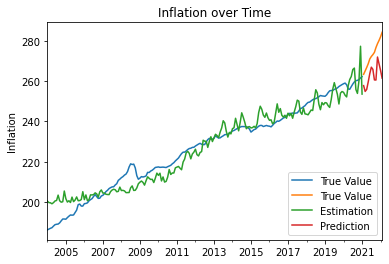

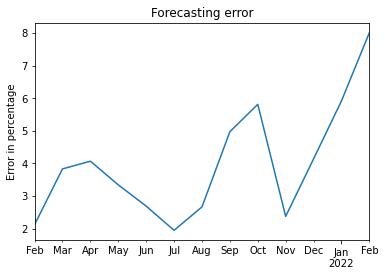

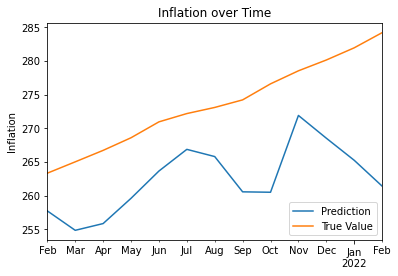

In [24]:
# Trying again to delete multicolinearity creating another new variable

y_test = data_test["CPI"]
X_test_ = data_test[['Fridge', 'Linkedin']]
X_test_["Settlement"] = (data_test["Car"] + data_test["Housing"] + data_test["Oil"])
X_test_["Travel"] = (data_test["Flight"] + data_test["Holidays"])
X_test = sm.add_constant(X_test_, has_constant='add')

y_train = data_train["CPI"]
X_train_ = data_train[['Fridge', 'Linkedin']]
X_train_["Settlement"] = (data_train["Car"] + data_train["Housing"] + data_train["Oil"])
X_train_["Travel"] = (data_train["Flight"] + data_train["Holidays"])
X_train = sm.add_constant(X_train_)

model_3 = sm.OLS(y_train, X_train)
model_3 = model_3.fit()
print(model_3.summary())
print(model_3.fvalue)

# Prediction
y_pred = model_3.predict(X_test)

# Plot prediction vs realized
data_train["CPI"].plot(kind='line', label='True Value')
data_test["CPI"].plot(kind='line', label='True Value')
model_3.predict(X_train).plot(kind='line', label='Estimation')
y_pred.plot(kind='line', label='Prediction')
plt.ylabel('Inflation')
plt.legend(loc='lower right')
plt.title("Inflation over Time")
plt.show()

# Error in percentage
error = abs(y_pred - y_test)/y_test * 100
error.plot(kind='line', label='Relative error')
plt.ylabel('Error in percentage')
plt.title("Forecasting error")
plt.show()

# Focus in prediction part
y_pred.plot(kind='line', label='Prediction')
y_test.plot(kind='line', label='True Value')
plt.ylabel('Inflation')
plt.legend(loc='lower right')
plt.title("Inflation over Time")
plt.show()

In [25]:
# Check for multicolinerity with VIF ( rule of thumb < max(10,1/1-R^2) )

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_.values, i) for i in range(len(X_train_.columns))]
vif_data = vif_data.sort_values("VIF", ascending=False)

print(vif_data)

      feature        VIF
3      Travel  29.363986
2  Settlement  28.438198
1    Linkedin   5.431308
0      Fridge   4.950661


# Appendix

## Other way of getting the data with csv files

In [ ]:
# Get the data from csv files

google = pd.read_csv (r'data_google_trends\multiTimeline_google.csv')
amazon = pd.read_csv (r'data_google_trends\multiTimeline_amazon.csv')
booking = pd.read_csv (r'data_google_trends\multiTimeline_booking.csv')
car = pd.read_csv (r'data_google_trends\multiTimeline_car.csv')
crisis = pd.read_csv (r'data_google_trends\multiTimeline_crisis.csv')
flight = pd.read_csv (r'data_google_trends\multiTimeline_flight.csv')
ford = pd.read_csv (r'data_google_trends\multiTimeline_ford.csv')
fridge = pd.read_csv (r'data_google_trends\multiTimeline_fridge.csv')
glassdoor = pd.read_csv (r'data_google_trends\multiTimeline_glassdoor.csv')
holidays = pd.read_csv (r'data_google_trends\multiTimeline_holidays.csv')
housing = pd.read_csv (r'data_google_trends\multiTimeline_housing.csv')
inflation = pd.read_csv (r'data_google_trends\multiTimeline_inflation.csv')
las_vegas = pd.read_csv (r'data_google_trends\multiTimeline_las_vegas.csv')
linkedin = pd.read_csv (r'data_google_trends\multiTimeline_linkedin.csv')
oil = pd.read_csv (r'data_google_trends\multiTimeline_oil.csv')
unemployment_benefits = pd.read_csv (r'data_google_trends\multiTimeline_unemployment_benefits.csv')
unemployment_insurance = pd.read_csv (r'data_google_trends\multiTimeline_unemployment_insurance.csv')
usajobs = pd.read_csv (r'data_google_trends\multiTimeline_usajobs.csv')
#get only data from 2004 since this is the start of our google trends
CPI_raw = pd.read_csv (r'data_google_trends\CPIAUCSL.csv')
CPI=CPI_raw[684:]
CPI

# We create lists of the different words and we set all elements marked by "<1" at zero

amazon_l = []
booking_l = []
car_l = []
crisis_l = []
flight_l = []
ford_l = []
fridge_l = []
glassdoor_l = []
holidays_l = []
housing_l = []
inflation_l = []
las_vegas_l = []
linkedin_l = []
oil_l = []
unemployment_benefits_l = []
unemployment_insurance_l = []
usajobs_l = []
google_l = []
CPI_l = []

for i in range(len(CPI)):
    amazon_l.append(amazon["amazon: (United States)"][i])
    amazon_l = ["0" if (i=="<1") else i for i in amazon_l]
    amazon_l = list(map(int, amazon_l))
    
    booking_l.append(booking["booking: (United States)"][i])
    booking_l = ["0" if (i=="<1") else i for i in booking_l]
    booking_l = list(map(int, booking_l))
    
    car_l.append(car["car: (United States)"][i])
    car_l = ["0" if (i=="<1") else i for i in car_l]
    car_l = list(map(int, car_l))
    
    crisis_l.append(crisis["crisis: (United States)"][i])
    crisis_l = ["0" if (i=="<1") else i for i in crisis_l]
    crisis_l = list(map(int, crisis_l))
    
    flight_l.append(flight["flight: (United States)"][i])
    flight_l = ["0" if (i=="<1") else i for i in flight_l]
    flight_l = list(map(int, flight_l))
    
    ford_l.append(ford["ford: (United States)"][i])
    ford_l = ["0" if (i=="<1") else i for i in ford_l]
    ford_l = list(map(int, ford_l))
    
    fridge_l.append(fridge["fridge: (United States)"][i])
    fridge_l = ["0" if (i=="<1") else i for i in fridge_l]
    fridge_l = list(map(int, fridge_l))
    
    glassdoor_l.append(glassdoor["GlassDoor: (United States)"][i])
    glassdoor_l = ["0" if (i=="<1") else i for i in glassdoor_l]
    glassdoor_l = list(map(int, glassdoor_l))
    
    holidays_l.append(holidays["holidays: (United States)"][i])
    holidays_l = ["0" if (i=="<1") else i for i in holidays_l]
    holidays_l = list(map(int, holidays_l))
    
    housing_l.append(housing["housing: (United States)"][i])
    housing_l = ["0" if (i=="<1") else i for i in housing_l]
    housing_l = list(map(int, housing_l))
    
    inflation_l.append(inflation["inflation: (United States)"][i])
    inflation_l = ["0" if (i=="<1") else i for i in inflation_l]
    inflation_l = list(map(int, inflation_l))
    
    las_vegas_l.append(las_vegas["las vegas: (United States)"][i])
    las_vegas_l = ["0" if (i=="<1") else i for i in las_vegas_l]
    las_vegas_l = list(map(int, las_vegas_l))
    
    linkedin_l.append(linkedin["LinkedIn: (United States)"][i])
    linkedin_l = ["0" if (i=="<1") else i for i in linkedin_l]
    linkedin_l = list(map(int, linkedin_l))
    
    oil_l.append(oil["oil: (United States)"][i])
    oil_l = ["0" if (i=="<1") else i for i in oil_l]
    oil_l = list(map(int, oil_l))
    
    unemployment_benefits_l.append(unemployment_benefits["unemployment benefits: (United States)"][i])
    unemployment_benefits_l = ["0" if (i=="<1") else i for i in unemployment_benefits_l]
    unemployment_benefits_l = list(map(int, unemployment_benefits_l))
    
    unemployment_insurance_l.append(unemployment_insurance["Unemployment Insurance: (United States)"][i])
    unemployment_insurance_l = ["0" if (i=="<1") else i for i in unemployment_insurance_l]
    unemployment_insurance_l = list(map(int, unemployment_insurance_l))
    
    usajobs_l.append(usajobs["USAJOBS: (United States)"][i])
    usajobs_l = ["0" if (i=="<1") else i for i in usajobs_l]
    usajobs_l = list(map(int, usajobs_l))
    
    google_l.append(google["Google: (États-Unis)"][i])
    google_l = ["0" if (i=="<1") else i for i in google_l]
    google_l = list(map(int, google_l))
    
    CPI_l.append(CPI["CPIAUCSL"][684+i])

    
    # Put the data in as a dataframe indexed by months

time = pd.period_range(start='2004-01-01',end='2022-02-01',freq='M')
data_csv = pd.DataFrame(index = time , 
                   data = {"Amazon": amazon_l,
                          "Booking": booking_l,
                          "Car": car_l,
                          "Crisis": crisis_l,
                          "Flight": flight_l,
                          "Ford": ford_l,
                          "Fridge": fridge_l,
                          "Glassdoor": glassdoor_l,
                          "Holidays": holidays_l,
                          "Inflation": inflation_l,
                          "Las Vegas": las_vegas_l,
                          "LinkedIn": linkedin_l,
                          "Oil": oil_l,
                          "Unemployment Benefits": unemployment_benefits_l,
                          "Unemployment Insurance": unemployment_insurance_l,
                          "USAjobs": usajobs_l,
                           "Google": google_l,
                          "CPI": CPI_l})
data_csv